This notebook is another implementation of the Biterm Topic Model as proposed <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.402.4032&rep=rep1&type=pdf">in this paper</a>. It utilizes the c++ script located at BTM/. <a href="https://github.com/xiaohuiyan/BTM"> Original Git repository</a>

In [1]:
import pandas as pd
from utils.lngselection import abbreviation
from wikiwho_wrapper import WikiWho
from external.wikipedia import WikipediaDV, WikipediaAPI
from metrics.conflict import ConflictManager
import numpy as np
import random
from BTM.script.topicDisplay import display_topics
import tqdm
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
from scipy.stats import entropy

Loading the page pickle:

In [3]:
from external.wikipedia import WikipediaDV, WikipediaAPI

def get_page(language_for_api, search_value):
    wikipedia_dv = WikipediaDV(WikipediaAPI(lng=language_for_api)) # create an instance
    result_after_search = wikipedia_dv.search_page(search_value)

    ## Get page id through get_page() method ##
    the_page = wikipedia_dv.get_page(result_after_search)  # global
    
    return the_page

In [2]:
# %%capture
# ## Some Extensions ##
# %load_ext autoreload
# %autoreload 2
# %store -r the_page

global lng, the_page

if 'the_page' not in locals():
    import pickle
    print("Loading default data...")
    the_page = pickle.load(open("data/the_page.p",'rb'))

lng = abbreviation('English')

Loading default data...


In [5]:
the_page = get_page(lng, "Genetically modified organism")

Initiating a wikiwho instance. Retrieving `all_content` for each token that has been changed and `revisions` for data about each revision. 

`ConflictManager` is used to retrieve conflicts and conflicting tokens. Dataframe `token` contains all tokens that have been changed on the page with information on revisions, original insertions and editors. `Tokens_processed` is a dataframe where each row corresponds to a revision and list of token_ids that have been changed during that revision.

In [6]:
wikiwho = WikiWho(lng=lng)
all_content = wikiwho.dv.all_content(the_page['page_id'])
revisions = wikiwho.dv.rev_ids_of_article(the_page['page_id'])

con_manager = ConflictManager(all_content.copy(), 
                                           revisions.copy(), 
                                           lng=lng, 
                                           include_stopwords=False)

In [7]:
con_manager.calculate()
token = con_manager.all_actions.copy()
tokens_processed = token[['rev_id', 'rev_time', 'editor', 'token_id', 'token']].groupby("rev_id")['token_id'].apply(lambda group_series: group_series.to_numpy()).reset_index()
tokens_processed

Preparing elegible token actions
Merge elegible actions and revisions
Get the conflicts
Calculate time differences of undos
Get elegible_actions
Calculate the token conflict


,rev_id,token_id
0,79585,"[340, 342, 344, 346]"
1,79784,"[336, 340, 342, 344, 346]"
2,175859,"[327, 363, 364, 367]"
3,175880,"[370, 372, 373, 374]"
4,254300,"[1, 2, 3, 6, 12, 14, 17, 21, 23, 26, 28, 31, 3..."
...,...,...
4714,985732441,"[7222, 172679, 172682, 172684, 172685, 172687]"
4715,985734954,"[7222, 172679, 172682, 172684, 172685, 172687]"
4716,989281228,"[46465, 59614, 76414, 76416, 76417, 93946, 944..."
4717,990704566,"[123934, 123941, 134624, 137529, 138548, 13858..."


If a revision contains only one token, that has been changed, this token_id is appended to either previous or next revision. `token_ids` contains a list of all unique token_ids. `X` is a a numpy array of `token_id` column. `vocab` is an array of all unique token_ids used in the article revisions.

In [8]:
for i, row in tokens_processed[np.array(list(map(len,tokens_processed.token_id.values)))==1].iterrows():
    k = random.choice([-1, 1])
    np.append(tokens_processed.loc[i+k, 'token_id'], row['token_id'][0])
    
tokens_processed = tokens_processed[np.array(list(map(len,tokens_processed.token_id.values)))>1] #dropping revisions with 1 token_id
token_ids = token[['token', 'token_id']].drop_duplicates()['token_id'].to_numpy()
X = tokens_processed['token_id'].to_numpy()
vocab = token[['token', 'token_id']].drop_duplicates()['token'].to_numpy()

The file <a href="BTM/input/input.txt">BTM/input/input.txt</a> is going to be an input fot the script. It contains the `tokens_processed['token_id']` in a string format.

In [9]:
#writing input ids for the C++ model

X_max = np.max([np.max(x) for x in X]) #the max token_id
wf = open('BTM/input/input.txt', 'w')
for x in tokens_processed['token_id']:
    print(' '.join(map(str, [str(it) for it in x])), file=wf)

the <a href="BTM/input/vocab.txt">BTM/input/vocab.txt</a> is going to be a vocabulary file for the script. It contains `vocab_dict` - a dictionary that maps token_ids to the words.

In [10]:
#writing the vocab file for the C++ model

vocab_dict = dict(zip(token_ids, vocab))
with open('BTM/input/vocab.txt', 'w', newline='\n') as f:
    for i in vocab_dict.keys():
        if i not in token_ids:
            f.write(str(i) + "\t" + "\n")
        else:
            f.write(str(i) + "\t" + vocab_dict[i] + "\n")

The variables for the script:

In [11]:
# INPUT VARIABLES FOR THE MODEL #
global niter, save_step, model_dir, doc_pt, voca_pt

K=15   # number of topics
alpha=0.1   #hyperparameter alpha
beta=0.01 #hyperparameter beta
niter=500    # number of iterations
save_step=100    # number of steps after which to save

model_dir='../output/model/' #a path for saving the output model to

doc_pt='../input/input.txt' # path to the doc with token ids
voca_pt='../input/vocab.txt' #path to the vocabulary

W = X_max #vocab size

The script itself is located at <a href="BTM/src/btm">BTM/src/btm</a>. To run it, firstly, the directory for the model is created at `model_dir`, then the script runs. It trains BTM over the documents and output the topics. The results will be written into the directory "model_dir":

k20.pw_z: a K*M matrix for P(w|z), suppose K=20

k20.pz: a K*1 matrix for P(z), suppose K=20

In [12]:
#run the model
%cd BTM/script

!mkdir -p {model_dir}
!make -C ../src/
!../src/btm est {K} {W} {alpha} {beta} {niter} {save_step} {doc_pt} {model_dir}

/home/jovyan/BTM/script
make: Entering directory '/home/jovyan/BTM/src'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/jovyan/BTM/src'
Run BTM, K=15, W=172912, alpha=0.1, beta=0.01, n_iter=500, save_step=100 ====
load docs: ../input/input.txt
Begin iteration
iter 100/500
write p(z): ../output/model/k15.pz
write p(w|z): ../output/model/k15.pw_z
iter 200/500
write p(z): ../output/model/k15.pz
write p(w|z): ../output/model/k15.pw_z
iter 300/500
write p(z): ../output/model/k15.pz
write p(w|z): ../output/model/k15.pw_z
iter 400/500
write p(z): ../output/model/k15.pz
write p(w|z): ../output/model/k15.pw_z
iter 500/500
write p(z): ../output/model/k15.pz
write p(w|z): ../output/model/k15.pw_z

write p(z): ../output/model/k15.pz
write p(w|z): ../output/model/k15.pw_z
cost 617.716597s


A python script <a href="BTM/script/topicDisplay.py">display_topics</a> illustrates the top words for the topics and their proportions in the collection. It also shows the links to the top-3 revision diffs that have most of the tokens from that topic.

In [13]:
#print output
topics, _ = display_topics(model_dir, K, voca_pt, tokens_processed, lng, the_page)

K:15, n(W):69244
Topic 1:
p(z): 0.071802
Top words:
gene:0.003854 tic:0.003790 techniques:0.003572 using:0.003326 altered:0.003295 organism:0.003283 material:0.003175 engineering:0.003091 genetic:0.003087 modified:0.003067

https://en.wikipedia.org/w/index.php?&title=Genetically_modified_organism&diff=173897949
https://en.wikipedia.org/w/index.php?&title=Genetically_modified_organism&diff=173898077
https://en.wikipedia.org/w/index.php?&title=Genetically_modified_organism&diff=188078394


Topic 2:
p(z): 0.070764
Top words:
70:0.003568 3240:0.003556 3244:0.003548 vitro:0.003449 plasmids:0.003445 bacterial:0.003285 insulin:0.003279 synthesis:0.003277 led:0.003234 recombinant:0.003234

https://en.wikipedia.org/w/index.php?&title=Genetically_modified_organism&diff=112415709
https://en.wikipedia.org/w/index.php?&title=Genetically_modified_organism&diff=120299008
https://en.wikipedia.org/w/index.php?&title=Genetically_modified_organism&diff=120299710


Topic 3:
p(z): 0.069970
Top words:
thera

The function `bow_corpus` creates a document corpus in BoW format for calculating the overall coherence score of the trained model (it is used for the evaluation of the topic models, more to read <a href="https://radimrehurek.com/gensim/models/coherencemodel.html">here</a>). The ranges are for C_V typically 0 < x < 1 and uMass -14 < x < 14

In [ ]:
global bow_corpus, dct


def bow_corpus(token_list):
    return [(_id, np.count_nonzero(token_list == _id)) for _id in token_list]

bow_corpus = tokens_processed['token_id'].apply(bow_corpus)
dct = Dictionary.from_corpus(bow_corpus)

cm = CoherenceModel(topics=topics, corpus=bow_corpus, dictionary=dct, coherence='u_mass')
coherence = cm.get_coherence()
print(f'The coherence score: {coherence}')

Next cells are used for parameter tuning. The loop runs for alpha from 0.1 to 5 with step 0.3 and beta from 0.01 to 1 with step 0.3. They are commented because the results are already saved at <a href="BTM/script/btm_tuning_results.csv">BTM/script/btm_tuning_results.csv</a>

C_v coherence measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

In [ ]:
# # Parameter tuning

# # Topics range
# min_topics = 5
# max_topics = 50
# step_size = 5
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.1, 5, 0.3))

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))

# model_results = { 'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence_C_V': [],
#                  'Coherence_C_U_mass': []
#                 }

# #texts in format list of lists of str (with token ids)
# texts = tokens_processed['token_id'].apply(lambda x: x.tolist()).tolist()
# texts = [[str(item) for item in text] for text in texts]

In [ ]:
# def compute_coherence_values(k, W, a, b, tokens_processed):
#     global niter, save_step, model_dir, doc_pt, voca_pt, bow_corpus, dct, lng, the_page, texts
#     !mkdir -p {model_dir}
#     !make -C ../src/
#     !../src/btm est {k} {W} {a} {b} {niter} {save_step} {doc_pt} {model_dir}
#     topics, _ = display_topics(model_dir, k, voca_pt, tokens_processed, lng, the_page)
#     cm_cv = CoherenceModel(topics=topics, texts = texts, corpus=bow_corpus, dictionary=dct, coherence='c_v')
#     cm_umass = CoherenceModel(topics=topics, corpus=bow_corpus, dictionary=dct, coherence='u_mass')
#     c_v = cm_cv.get_coherence()
#     c_u_mass = cm_umass.get_coherence()
#     return c_v, c_u_mass

# if 1 == 1:
#     pbar = tqdm.tqdm(total=540)

#     # iterate through number of topics
#     for k in topics_range:
#         # iterate through alpha values
#         for a in alpha:
#             # iterare through beta values
#             for b in beta:
#                 # get the coherence score for the given parameters
#                 c_v, c_u_mass = compute_coherence_values(k, W, a, b, tokens_processed)
#                 # Save the model results
#                 model_results['Topics'].append(k)
#                 model_results['Alpha'].append(a)
#                 model_results['Beta'].append(b)
#                 model_results['Coherence_C_V'].append(c_v)
#                 model_results['Coherence_C_U_mass'].append(c_u_mass)

#                 pbar.update(1)
#     btm_cv = pd.DataFrame(model_results)#.to_csv('btm_tuning_results.csv', index=False)
#     pbar.close()

The results of parameter tuning:

In [ ]:
#btm_cv.to_csv('btm_tuning_results.csv', index=False) #for saving after the loop
btm_cv = pd.read_csv('btm_tuning_results.csv')
btm_cv

Selecting the parameters with highest C_U_mass:

In [ ]:
btm_cv.iloc[btm_cv['Coherence_C_U_mass'].idxmax()]

Selecting the parameters with highest C_V:

In [ ]:
btm_cv.iloc[btm_cv['Coherence_C_V'].idxmax()]  #high coherence because tokens mostly appear together in most of the documents 

To understand it better, the visualisation for all 3 parameters (x-axis) and coherence scores (y-axis) is provided:

In [ ]:
print('Graph of coherence U_Mass:')
fig, axs = plt.subplots(3,1, figsize=(10, 10))

btm_topics = btm_cv.groupby('Topics')['Coherence_C_U_mass'].agg('max')
btm_alpha = btm_cv.groupby('Alpha')['Coherence_C_U_mass'].agg('max')
btm_beta = btm_cv.groupby('Beta')['Coherence_C_U_mass'].agg('max')
btm_topics.plot.line(x='Topics', y='Coherence_C_U_mass', ax=axs[0])
btm_alpha.plot.line(x='Alpha', y='Coherence_C_U_mass', ax=axs[1])
btm_beta.plot.line(x='Bets', y='Coherence_C_U_mass', ax=axs[2])

In [ ]:
print('Graph of coherence C_V:')
fig, axs = plt.subplots(3,1, figsize=(10, 10))

btm_topics = btm_cv.groupby('Topics')['Coherence_C_V'].agg('max')
btm_alpha = btm_cv.groupby('Alpha')['Coherence_C_V'].agg('max')
btm_beta = btm_cv.groupby('Beta')['Coherence_C_V'].agg('max')
btm_topics.plot.line(x='Topics', y='Coherence_C_V', ax=axs[0])
btm_alpha.plot.line(x='Alpha', y='Coherence_C_V', ax=axs[1])
btm_beta.plot.line(x='Bets', y='Coherence_C_V', ax=axs[2])

Now training the model using the best parameters found. <b>Please update them accordingly</b>:

In [14]:
#best_model 
!mkdir -p {model_dir}
!make -C ../src/
!../src/btm est {10} {W} {2.8} {0.31} {niter} {save_step} {doc_pt} {model_dir} #change the numbers here for your parameters

make: Entering directory '/home/jovyan/BTM/src'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/jovyan/BTM/src'
Run BTM, K=10, W=172912, alpha=2.8, beta=0.31, n_iter=500, save_step=100 ====
load docs: ../input/input.txt
Begin iteration
iter 100/500
write p(z): ../output/model/k10.pz
write p(w|z): ../output/model/k10.pw_z
iter 200/500
write p(z): ../output/model/k10.pz
write p(w|z): ../output/model/k10.pw_z
iter 300/500
write p(z): ../output/model/k10.pz
write p(w|z): ../output/model/k10.pw_z
iter 400/500
write p(z): ../output/model/k10.pz
write p(w|z): ../output/model/k10.pw_z
iter 500/500
write p(z): ../output/model/k10.pz
write p(w|z): ../output/model/k10.pw_z

write p(z): ../output/model/k10.pz
write p(w|z): ../output/model/k10.pw_z
cost 475.905335s


Printing the topics the best model has inferred:

In [15]:
#output of model with best parameters
best_topics, orig_topics = display_topics(model_dir, 10, voca_pt, tokens_processed, lng, the_page)

best_topics_tokens = [[vocab_dict[int(token)] for token in tokens] for tokens in best_topics]

K:10, n(W):69244
Topic 1:
p(z): 0.108880
Top words:
gene:0.002432 genetic:0.002430 engineering:0.002429 tic:0.002395 techniques:0.002220 organism:0.002160 sold:0.002110 pet:0.002092 animal:0.002086 glofish:0.002074

https://en.wikipedia.org/w/index.php?&title=Genetically_modified_organism&diff=188078394
https://en.wikipedia.org/w/index.php?&title=Genetically_modified_organism&diff=188078409
https://en.wikipedia.org/w/index.php?&title=Genetically_modified_organism&diff=267574640


Topic 2:
p(z): 0.102949
Top words:
conventionally:0.001433 bred:0.001433 crop:0.001433 pollen:0.001433 modified:0.001433 gm:0.001433 proponents:0.001433 pollinated:0.001431 raised:0.001427 critics:0.001414

https://en.wikipedia.org/w/index.php?&title=Genetically_modified_organism&diff=25356199
https://en.wikipedia.org/w/index.php?&title=Genetically_modified_organism&diff=31202056
https://en.wikipedia.org/w/index.php?&title=Genetically_modified_organism&diff=31202470


Topic 3:
p(z): 0.099654
Top words:
reason:

The WordCloud visualisation of the previous cell

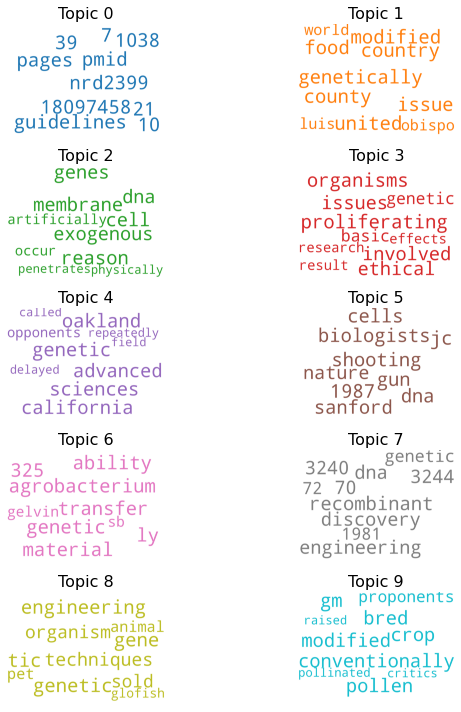

In [16]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

i = 0
best_topics_format = []
for it in orig_topics.values():
    items_split = it[0].split()
    items_format = [(item.split(':')[0], float(item.split(':')[1])) for item in items_split]
    best_topics_format.append((i, items_format))
    i += 1

#topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(best_topics_format[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()